# Clem's Machine Learning Template
## HR Data

This is what Clem uses to scout out an initial data set for classification to get a "lay of the land".

While, it is unwise to favor a particular ML methodology, H2O's GBM has a lot of advantages that makes it really good for a first pass:

* Fast
* Robust to overfitting over a wide range of hyper parameters
* Handles both categorical and continous variables
* No need to scale the data

Change sections that are labeled:

    #@@@@@ CHANGE FOR SPECIFIC PROBLEM

This data is from https://www.kaggle.com/ludobenistant/hr-analytics


## Data Preparation

In [1]:
# Python Libraries
from __future__ import division   # So that / does floating point division
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import commands
import math
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.mosaicplot import mosaic
import pylab

import h2o

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [2]:
#@@@@@ CHANGE FOR SPECIFIC PROBLEM

# Column names in case they aren't in an header

column_names =[
]

In [3]:
#@@@@@ CHANGE FOR SPECIFIC PROBLEM

# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

# Very Problem specific

df = pd.read_csv(
    "HR_comma_sep.csv",
    sep=",",
    header=0,   # Row the header is on or None if no header present
    # names=column_names,
    # skipinitialspace = True  # Skip spaces after delimiter
)



In [4]:
# Names of columns - check to see if we got it right
df.columns.values

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'left', 'promotion_last_5years', 'sales', 'salary'], dtype=object)

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
#@@@@@ CHANGE FOR SPECIFIC PROBLEM
# Drop any columns that don't make sense, if any
if False:
    df = df.drop("COLUMN-NAME-THAT-IS-USELESS",  #
                 1)  # 1 means drops in column direction
    
# Fix up any data

## Get Names of Columns

### Problem Specific
These are the values that are problem specific.  We use variable names from now on so that the code can be reused.

In [7]:
#@@@@@ CHANGE FOR SPECIFIC PROBLEM
YName = 'left'     # Name of Response Variable
XUnknowCategoricalValue = None  # or string that represents no categorical





In [8]:
# Automatically convert response variable that are ints
# into catgorical values
if df[YName].dtype == 'int64':
    df[YName] = df[YName].astype("category", ordered=False)


Programmatically get list of names of:
* numeric features
* non-numeric features


In [9]:
# Names of all the input features 
XNames = [x for x in df.columns.values if x != YName]

# Names of all the Non-Numeric input features
XNonNumerics = [x for x in XNames \
                if not (df[x].dtype == np.float64 \
                        or df[x].dtype == np.int64)]

# Names of all the Non-Numeric input features
XNumerics = [x for x in XNames if x not in XNonNumerics]

# All the different Classification values that Y can take on
YValues = list(df[YName].unique())

print("-- Non-Numeric Input Feature Names:")
print(XNonNumerics)   # Of type pandas.core.series.Series
print("\n-- Numeric Input Feature Names:")
print(XNumerics)
print("\n-- All Input Feature Names:")
print(XNames)
print("\n-- Output (Response) Variable name:")
print(YName)
print("\n-- All possible values of Output (Response Variable):")
print(YValues)   # Classification values

-- Non-Numeric Input Feature Names:
['sales', 'salary']

-- Numeric Input Feature Names:
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']

-- All Input Feature Names:
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'sales', 'salary']

-- Output (Response) Variable name:
left

-- All possible values of Output (Response Variable):
[1, 0]


## Data Exploration

Here, we plot the data to get a sense of which data

In [10]:
df[XNumerics].dtypes 

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
promotion_last_5years      int64
dtype: object

In [11]:
# how balanced is the data
for w in YValues:
    s = sum(list(df[YName] == w))
    print("{} is {:.1f}%".format(w,
                             100*s/len(df)))

1 is 23.8%
0 is 76.2%


### Numeric Data

In [12]:
df[XNumerics].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [13]:
for xname in XNumerics:
    uniques = len(df[xname].unique())
    dtype = df[xname].dtypes
    if dtype == 'int64':
        range_x = df[xname].max() - df[xname].min() + 1
        print(
            "{} has {} int uniques with a density of {:.1f}% in range {}".format(
            xname, uniques, 100.0*uniques/range_x, range_x))
    else:
        range_x = df[xname].max() - df[xname].min()
        print("{} has {} float64 uniques in a range {:.1f}".format(
            xname, uniques, range_x))
       

satisfaction_level has 92 float64 uniques in a range 0.9
last_evaluation has 65 float64 uniques in a range 0.6
number_project has 6 int uniques with a density of 100.0% in range 6
average_montly_hours has 215 int uniques with a density of 100.0% in range 215
time_spend_company has 8 int uniques with a density of 88.9% in range 9
Work_accident has 2 int uniques with a density of 100.0% in range 2
promotion_last_5years has 2 int uniques with a density of 100.0% in range 2


In [14]:
# Number of unknown Numeric Values
nrow = len(df)
for xname in XNumerics:
    count =  (df[xname].apply(math.isnan)).sum()
    if count > 0:
        print ("{} has {} '{}'s which is {:.1f}%".format(
            xname,
            count,
            XUnknowCategoricalValue,
            100.0*count/nrow))


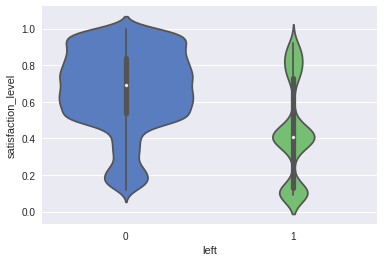

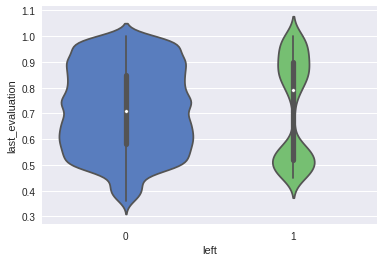

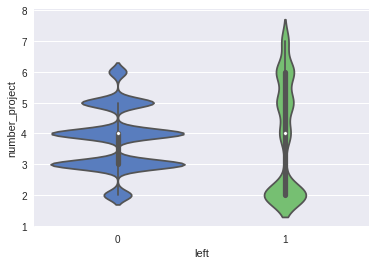

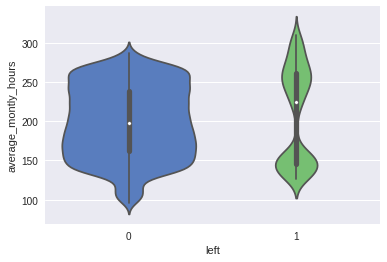

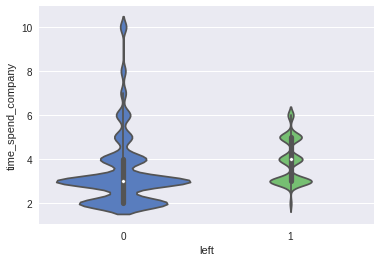

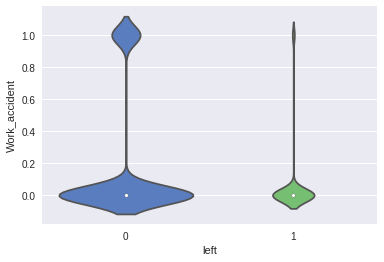

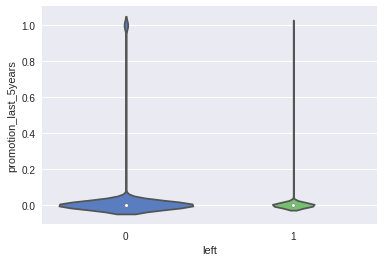

In [15]:
# Violin Plot of numeric data
for x in XNumerics:
    sns.violinplot(y = df[x],
                   x = df[YName],
                   # Width indicates relative count.  >50K is less frequent
                   scale="count" , 
                   inner="box",
                   palette="muted",
                   split=True
                  )
    plt.show()

### Non-Numeric Data

In [16]:
for xname in XNonNumerics:
    uniques = len(df[xname].unique())
    print("{} has {} uniques".format(
        xname, uniques))

sales has 10 uniques
salary has 3 uniques


In [17]:
# Number of unknown NonNumeric Values
nrow = len(df)
for xname in XNonNumerics:
    count =  (df[xname] == XUnknowCategoricalValue).sum()
    if count > 0:
        print ("{} has {} '{}'s which is {:.1f}%".format(
            xname,
            count,
            XUnknowCategoricalValue,
            100.0*count/nrow))
        

In [18]:
df[XNonNumerics].describe().transpose()

,count,unique,top,freq
sales,14999,10,sales,4140
salary,14999,3,low,7316


### Number of unknown categorical values



In [19]:
nrow = len(df)
for xname in XNonNumerics:
    count =  (df[xname] == XUnknowCategoricalValue).sum()
    if count > 0:
        print ("{} has {} Unknowns which is {:.1f}%".format(
            xname, count, 100.0*count/nrow))
        

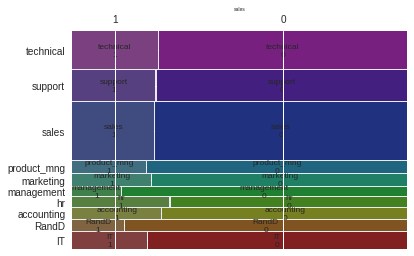

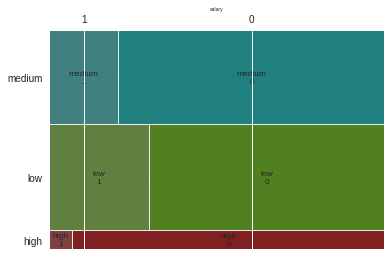

In [20]:
plt.rcParams['font.size'] = 10.0
# http://www.statsmodels.org/0.6.1/generated/statsmodels.graphics.mosaicplot.mosaic.html
    
for x in XNonNumerics:
    m = mosaic(df[[x, YName]],
           [x, YName],
           horizontal=False
          )
    pylab.xlabel(x, fontsize =5)
    pylab.show()

## Using H2O to get a first impression of variable importance

While the assignment prefers, a more "fundamental" approach, it has been my experience that running an initial H2O GBM (Gradient Boosted Machine) model has a number of advantages which are useful for gaining a first impression of the data.

H2O GBM

* has no need to scale the data
* can handle both categorical and continous features
* is robust against overfitting
* general builds a very good model
* is fast
* can show you variable importance in the model it builds.

However, the "No Free Lunch Theorem", does caution us from depending blindly on any one model.  https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization

George Box also says, "All models are wrong, but some are useful."

In [21]:
PName = "predict"   # The name of the predict field for H2O output
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /usr/local/anaconda2/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd1PEp9
  JVM stdout: /tmp/tmpd1PEp9/h2o_clem_started_from_python.out
  JVM stderr: /tmp/tmpd1PEp9/h2o_clem_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_clem_1ln428
H2O cluster total nodes:,1
H2O cluster free memory:,6.973 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [22]:
# Make the H2O version of the data frame
dfh = h2o.H2OFrame(df)
dfh[YName] = dfh[YName].asfactor()   # Force response

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
dfh[YName].anyfactor()

True

In [24]:
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

# For doing a grid search, see here:
# https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
    
    
gbm = h2o.estimators.gbm.H2OGradientBoostingEstimator(
   # nfolds=4,
   #     ntrees=5,
   #     max_depth=5,    # Of a tree
)
x = """
    # DEFAULTS:
    nfolds = 0,    # No cross validation folds
    ntrees=50,
    learn_rate=0.1,
    max_depth=5,    # Of a tree
    min_row=10,     # Fewest allowed observations in a leaf (weighted)
    nbins=20,   # For numeric cols, build histogram of at most this many bins
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    stopping_rounds=2,
    score_each_iteration=True,
"""

In [25]:
gbm.train(x=XNames, y=YName, training_frame=dfh)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
pred_train = gbm.predict(dfh)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [27]:
print ("Training error = {:.3f}".format(
    1 - (pred_train['predict'] == dfh[YName]).sum()/dfh.nrows))

print ("Training accuracy = {:.3f}".format(
    (pred_train['predict'] == dfh[YName]).sum()/dfh.nrows))


Training error = 0.019
Training accuracy = 0.981


In [28]:
pred_train

predict,p0,p1
1,0.0231102,0.97689
1,0.180919,0.819081
1,0.0118534,0.988147
1,0.049089,0.950911
1,0.0231102,0.97689
1,0.0231102,0.97689
1,0.013452,0.986548
1,0.048097,0.951903
1,0.0336916,0.966308
1,0.0231102,0.97689


In [29]:
df[YName].dtype

category

### F1 Score


$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

See:

https://en.wikipedia.org/wiki/F1_score

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html


In [30]:
# Multinominal classifier
f1 = f1_score(dfh[YName].as_data_frame()[YName].tolist(),
     pred_train[PName].as_data_frame()[PName].tolist(),
     average=None,         
     labels=YValues
     )    
for i, yvalue in enumerate(YValues):
    print("F1 Score for y = '{}' is {:.3f}".format(yvalue, f1[i]))


F1 Score for y = '1' is 0.959
F1 Score for y = '0' is 0.988


### ROC

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html


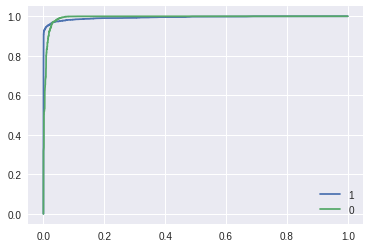

-- AUC is 0.993


In [31]:
for i, yvalue in enumerate(YValues):
    # Get the True and Predicted values
    y_true = list(df[YName])
    y_true = map(lambda x : 1 if x == yvalue else 0, y_true)

    # These are the predicted probabilities
    if type(yvalue) is str:
        yvalue_column_name = yvalue
        y_pred = pred_train[yvalue].as_data_frame()[yvalue].tolist()
    else:
        yvalue_column_name = "p" + str(yvalue)
        y_pred = (pred_train.as_data_frame()[yvalue_column_name].tolist())

    # Area Under the ROC Curve (AUC)
    auc = roc_auc_score(y_true, y_pred)
    FalsePositiveRate, TruePositiveRate, thresholds = roc_curve(
        y_true,
        y_pred)
    pylab.plot(FalsePositiveRate,
                           TruePositiveRate,
                           label=yvalue)
pylab.legend(loc='lower right', shadow=True)
pylab.show()

print("-- AUC is {:.3f}".format(auc))


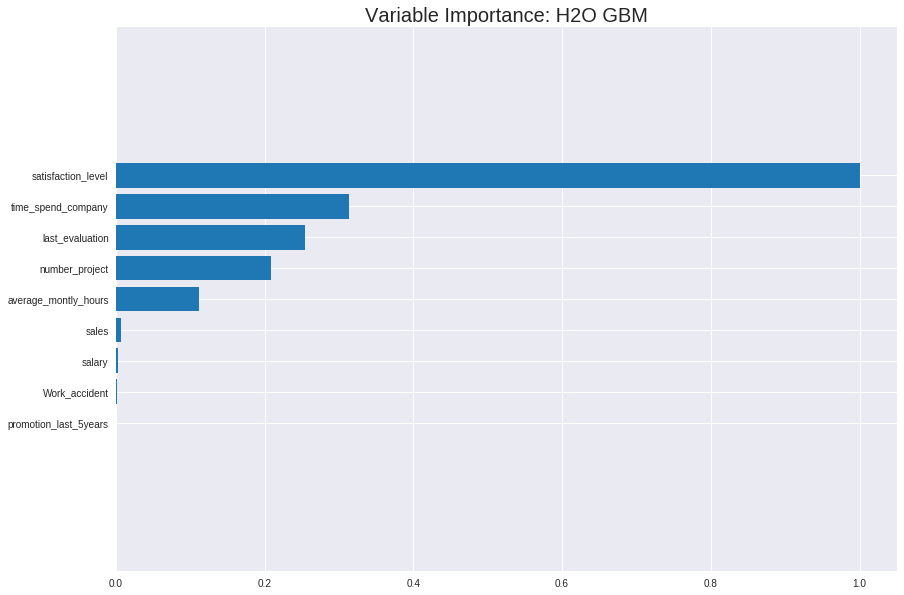

In [32]:
gbm.varimp_plot()

In [33]:
varimp = pd.DataFrame(gbm.varimp(),
             columns=
             ["variable",
              "relative_importance",
              "scaled_importance",
              "percentage"]
            )
top5 = varimp['variable'][0:5].tolist() + [YName]
varimp

,variable,relative_importance,scaled_importance,percentage
0,satisfaction_level,6767.692383,1.000000,0.526354
1,time_spend_company,2118.022949,0.312961,0.164728
2,last_evaluation,1721.129028,0.254315,0.133860
3,number_project,1409.998047,0.208343,0.109662
4,average_montly_hours,759.435059,0.112215,0.059065
5,sales,52.549866,0.007765,0.004087
6,salary,18.600296,0.002748,0.001447
7,Work_accident,10.255219,0.001515,0.000798
8,promotion_last_5years,0.000000,0.000000,0.000000


In [34]:
# TBD - figure out a pairs plot for top 5 most important variables
#  -- tricky - how to do it with both categorical and numeric values

# from pandas.tools.plotting import scatter_matrix
# scatter_matrix(df[top5],

#### df[top5].plot(subplots=True, layout)

In [35]:
if False:
    h2o.cluster().shutdown(prompt = False)